STARTED:      2/26/25

LAST UPDATED: 3/4/25

By Eugene Fong

# GOAL(S)

- Pseudobulk on the SN data

# #* TODO

XYLENA: 
- pseudobulk each category (young/old) then run w/the tools Adam used
- avg's expression of each cell type in each sample
- should have a tool in scanpy
- also in Adam's pipeline

ADAM
- break up the adata obj into indiv clusters by cell type for the trajectory analysis
- redo the DGE by cell type, 
- use the leiden_2 cluster

Pseudo-bulking = collapsing into counts the mean expression for that sample
- sum is better for genes that are lowly expressed by highly variable betw samples
- mean is better for genes that are highly expressed genes

Lit review on pseudotime and trajectory analysis tools, run by some suggestions by Xylena before starting on one

# CHANGE - choose your cell type:

```
cell_type[0] = DaN
cell_type[1] = ExN
cell_type[2] = EC
cell_type[3] = Oligo
cell_type[4] = Astro
cell_type[5] = OPC
cell_type[6] = PC
cell_type[7] = MG
cell_type[8] = InN
cell_type[9] = TC
```

In [44]:
cell_type_number = 0

# LOAD DATA

### DEFINE PATHS

In [2]:
# INPUT - my mod'ed .h5ad file
input_file = '/vf/users/CARD_singlecell/SN_control_atlas/multiome-pipeline/src/output/05_annotated_anndata_rna-ef-rank_genes_groups.h5ad'

In [3]:
# # OUTPUT - file path for my testing, base on the original file name
# output_file = os.path.join('output', os.path.basename(input_file).replace('.h5ad', '-ef-rank_genes_groups.h5ad'))
# print('output_file =', output_file)

# PSEUDOBULK + DGE

#* TODO

- run Adam's updated rna_DGE.py script in JNB (copy and paste?)
- will need to edit some of the variables
- read up on DESEQ2 and Decouplr

Can figure out how ot pull GH properly laterrrr

### REFS: 

- Adam's DGE snakemake rule
- Pseudo-bulk: [https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html)
- DESeq2 (original in R): [https://bioconductor.org/packages/release/bioc/html/DESeq2.html](https://bioconductor.org/packages/release/bioc/html/DESeq2.html)
- PyDESeq2 (Python vers): [https://pydeseq2.readthedocs.io/en/stable/](https://pydeseq2.readthedocs.io/en/stable/)

# INSTALLS  

In [4]:
# %pip install pydeseq2

SOURCE: Adam's `rna_DGE.py` snakemake rule

# IMPORTS

In [5]:
# import anndata as ad
# import scipy
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import pprint
import os

/data/fonge2/conda/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/fonge2/conda/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/fonge2/conda/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/fonge2/conda/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/fonge2/conda/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.


# LOAD DATA

In [6]:
# # Open RNA
# adata = sc.read_h5ad(snakemake.input.rna_anndata)
adata = sc.read_h5ad(input_file)

In [7]:
# CHECK
pprint.pprint(adata)

AnnData object with n_obs × n_vars = 477356 × 35633
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'cell_barcode', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'sample', 'short diagnosis', 'S_score', 'G2M_score', 'phase', 'n_counts', 'atlas_identifier', 'leiden_2', 'leiden', 'leiden_05', 'cell_type', 'age_old', 'age_bin', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_t

# DEFINE VARIABLES

In [8]:
# # Define the cell types to look for
# cell_types = ['Astro', 'DaN', 'ExN', 'EC', 'InN', 'MG', 'OPC', 'Oligo', 'PC', 'TC']

# EXTRACT - cell types from the unique values in the 'cell_type' column
cell_types = list(adata.obs['cell_type'].unique())
print('cell_types =', cell_types)
# print('cell_types[0] =', cell_types[0])

cell_types = ['DaN', 'ExN', 'EC', 'Oligo', 'Astro', 'OPC', 'PC', 'MG', 'InN', 'TC']


In [9]:
# # # Define disease states

# EXTRACT - the control and disease states from the unique values in the 'age_bin' column
col_of_interest = 'age_bin'
young = list(adata.obs[col_of_interest].unique())[0:1]
old = list(adata.obs[col_of_interest].unique())[1:]

# CHECK
print('young =', young)
print('old =', old)

young = ['young (< 57.9)']
old = ['old (>= 57.9)']


In [12]:
# #* TODO - as a for loop?
# # Read in parameters
# cell_type       = snakemake.params.cell_type
# disease_name    = snakemake.params.disease
# control_name    = snakemake.params.control

In [13]:
# # SUBSET - the data for the cell type
# adata = adata[adata.obs['cell_type'] == cell_type].copy()

counter = 0

for cell_type in cell_types:
    print(f'cell_type[{counter}] = {cell_type}')
    counter += 1
    # adata = adata[adata.obs['cell_type'] == cell_type].copy()

cell_type[0] = DaN
cell_type[1] = ExN
cell_type[2] = EC
cell_type[3] = Oligo
cell_type[4] = Astro
cell_type[5] = OPC
cell_type[6] = PC
cell_type[7] = MG
cell_type[8] = InN
cell_type[9] = TC


In [14]:
# CHECK
adata.obs['cell_type']

GCACGAACAATGAATG-1_890         DaN
CCACAATAGTCAGGCC-1_890         ExN
CTGCAATAGTGTTGCG-1_890         ExN
GAGTGAGGTCATGAGC-1_890         DaN
GCTCAACCAGCATGTC-1_890          EC
                             ...  
ATTTAGGTCATAACCA-1_SP5256       PC
GCTAAGAAGGCAATAG-1_SP5256    Oligo
AGCCTAGTCCTCATCA-1_SP5256    Oligo
AGCAAGGGTGGATTGC-1_SP5256       PC
CACATGCCAGTCTATG-1_SP5256    Astro
Name: cell_type, Length: 477356, dtype: category
Categories (10, object): ['Astro', 'DaN', 'EC', 'ExN', ..., 'OPC', 'Oligo', 'PC', 'TC']

In [15]:
# CHECK
adata[adata.obs['cell_type'] == cell_types[0]]

View of AnnData object with n_obs × n_vars = 4217 × 35633
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'cell_barcode', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'sample', 'short diagnosis', 'S_score', 'G2M_score', 'phase', 'n_counts', 'atlas_identifier', 'leiden_2', 'leiden', 'leiden_05', 'cell_type', 'age_old', 'age_bin', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'l

In [ ]:
# CHANGE - for each cell type
selected_cell_type = cell_types[cell_type_number]
print('selected_cell_type =', selected_cell_type)

selected_cell_type = DaN


In [17]:
#* TODO - go thru 1 cell type at a time before you make a loop

# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata[adata.obs['cell_type'] == selected_cell_type].copy(),
    sample_col  = 'sample',
    groups_col  = 'cell_type',
    layer       = 'counts',
    mode        = 'sum',
    min_cells   = 10,
    min_counts  = 10
)

In [18]:
# CHECK
pdata

AnnData object with n_obs × n_vars = 89 × 31964
    obs: 'sample', 'cell_type', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'short diagnosis', 'age_old', 'age_bin', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [19]:
# CONVERT - age col into float types
pdata.obs['age'] = pdata.obs.age.astype('float')

# CHECK
pdata.obs['age']

1023_DaN       63.0
1105_DaN       44.2
1135_DaN       60.4
1179_DaN       45.4
1187_DaN       21.5
               ... 
PT13818_DaN    67.0
S05135_DaN     86.0
S14752_DaN     76.0
S15709_DaN     81.0
SP5568_DaN     65.0
Name: age, Length: 89, dtype: float64

In [20]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# CHECK
pdata.X.copy()

array([[  4.,   5.,   1., ...,  13., 103.,   0.],
       [  0.,   3.,   0., ...,   2.,   6.,   0.],
       [  0.,   0.,   3., ...,   8.,  42.,   0.],
       ...,
       [  0.,   1.,   0., ...,   4.,  41.,   0.],
       [  0.,   1.,   1., ...,   5.,  20.,   0.],
       [  3.,   1.,   1., ...,   9.,  43.,   0.]], dtype=float32)

In [21]:
# Normalize, scale and compute PCA
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

In [22]:
# Return raw counts to X
dc.swap_layer(
    pdata, 
    'counts', 
    X_layer_key = None, 
    inplace = True
)

In [23]:
# # RENAME - col names with a space in the name will be problematic
# # Abreviate diagnosis
# pdata.obs['diagnosis'] = pdata.obs['Primary Diagnosis']

In [24]:
# NORMALIZE - ages and shift the center to 0 so positive #'s = old, negative #'s = young
ages = pdata.obs.age

#? Q) What is this doing?
#? A) Normalizing the ages to be 0 - 1, and then shifting the center to 0 so the range is now -0.5 to 0.5
#?    Then the old = positive #'s and the young = negative #'s
pdata.obs['normalage'] = (ages - np.min(ages)) / (np.max(ages) - np.min(ages)) - 0.5

# # CHECK
# print('ages = \n', ages, '\n')
# print('np.min(ages) =', np.min(ages))
# print('np.max(ages) =', np.max(ages))
# print('np.max(ages) - np.min(ages) =', np.max(ages) - np.min(ages))

In [25]:
# CHECK
print(pdata.obs.columns)

Index(['sample', 'cell_type', 'batch', 'sex', 'age', 'pmi', 'ethnicity',
       'race', 'brain_bank', 'homogenization', 'library', 'seq',
       'short diagnosis', 'age_old', 'age_bin', 'psbulk_n_cells',
       'psbulk_counts', 'normalage'],
      dtype='object')


In [26]:
# # FIX - space in name
# pdata.obs['short_diagnosis'] = pdata.obs['short diagnosis']

In [ ]:
#* TODO - check up what this command is doing

dc.get_metadata_associations(
    pdata,
    obs_keys = [
        'normalage', 
        # 'short_diagnosis', 
        'age_bin',
        'psbulk_n_cells', 
        'psbulk_counts'
        ],                      # Metadata columns to associate to PCs
    obsm_key    = 'X_pca',      # Where the PCs are stored
    uns_key     = 'pca_anova',  # Where the results are stored
    inplace     = True,
)

In [28]:
# CHECK
pdata

AnnData object with n_obs × n_vars = 89 × 31964
    obs: 'sample', 'cell_type', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'short diagnosis', 'age_old', 'age_bin', 'psbulk_n_cells', 'psbulk_counts', 'normalage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [29]:
# NOTE - i'm not using this col
# pdata.obs.short_diagnosis

In [30]:
# FILTER - genes with low expression
pdata_genes = dc.filter_by_expr(
    pdata, 
    # group           = 'diagnosis', 
    # group           = 'short_diagnosis', 
    group           = 'age_bin',
    min_count       = 10, 
    min_total_count = 15
    )

# CHECK
pdata_genes

array(['AACS', 'AAGAB', 'AAK1', ..., 'ZXDC', 'ZYG11B', 'ZZEF1'],
      dtype='<U17')

In [31]:
# CHECK
pdata[:, pdata_genes]

View of AnnData object with n_obs × n_vars = 89 × 6122
    obs: 'sample', 'cell_type', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'short diagnosis', 'age_old', 'age_bin', 'psbulk_n_cells', 'psbulk_counts', 'normalage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [32]:
pdata = pdata[:, pdata_genes].copy()
pdata

AnnData object with n_obs × n_vars = 89 × 6122
    obs: 'sample', 'cell_type', 'batch', 'sex', 'age', 'pmi', 'ethnicity', 'race', 'brain_bank', 'homogenization', 'library', 'seq', 'short diagnosis', 'age_old', 'age_bin', 'psbulk_n_cells', 'psbulk_counts', 'normalage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt', 'rb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [33]:
#? Q) Is it ok to have normalage and age_bin in the design_factors?
#? A) nooooooo, both are looking at a similar stat

inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    adata           = pdata[pdata.obs['cell_type'] == selected_cell_type].copy(),
    design_factors  = ['age_bin', 'batch'],
    refit_cooks     = True,
    inference       = inference,
)

# Compute LFCs
dds.deseq2()

/tmp/ipykernel_2998914/350292461.py:6: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.43 seconds.

Fitting dispersion trend curve...
/data/fonge2/conda/lib/python3.10/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 2.23 seconds.

Fitting LFCs...
... done in 1.69 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 213 outlier genes.

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.10 seconds.



In [34]:
# EXTRACT - contrast between young and old
stat_res = DeseqStats(
    dds,
    contrast    = ["age_bin", young[0] , old[0] ],
    inference   = inference,
)

In [35]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: age_bin young (< 57.9) vs old (>= 57.9)
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AACS     14.304684       -0.022562  0.105117 -0.214636  0.830051  0.975078
AAGAB    16.056164       -0.001294  0.115332 -0.011216  0.991051  0.997316
AAK1    114.834743       -0.102229  0.071116 -1.437499  0.150576  0.677464
AARS     18.340447        0.003248  0.147284  0.022051  0.982407  0.995254
AARSD1    9.694544        0.125859  0.149119  0.844019  0.398659       NaN
...            ...             ...       ...       ...       ...       ...
ZUP1      7.818206        0.139048  0.132806  1.047001  0.295099       NaN
ZW10      8.821378        0.370893  0.124239  2.985313  0.002833       NaN
ZXDC     17.317768       -0.133120  0.099821 -1.333581  0.182341  0.701100
ZYG11B   27.167553       -0.103216  0.095281 -1.083275  0.278686  0.784761
ZZEF1    38.621339       -0.097607  0.139701 -0.698682  0.484751  0.884246

[6122 rows x 6 column

... done in 0.60 seconds.



In [36]:
# EXTRACT - results to DF
DGE_results_df = stat_res.results_df
DGE_results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AACS,14.304684,-0.022562,0.105117,-0.214636,0.830051,0.975078
AAGAB,16.056164,-0.001294,0.115332,-0.011216,0.991051,0.997316
AAK1,114.834743,-0.102229,0.071116,-1.437499,0.150576,0.677464
AARS,18.340447,0.003248,0.147284,0.022051,0.982407,0.995254
AARSD1,9.694544,0.125859,0.149119,0.844019,0.398659,NaN
...,...,...,...,...,...,...
ZUP1,7.818206,0.139048,0.132806,1.047001,0.295099,NaN
ZW10,8.821378,0.370893,0.124239,2.985313,0.002833,NaN
ZXDC,17.317768,-0.133120,0.099821,-1.333581,0.182341,0.701100
ZYG11B,27.167553,-0.103216,0.095281,-1.083275,0.278686,0.784761


In [37]:
#? Q) What is this doing?
# - Creating a new col based on the negative log 10 of padj???
# NOTE: negative log₁₀ values represent increasingly smaller decimal numbers. Each decrease by 1 in the negative log₁₀ represents dividing by 10
DGE_results_df['-log10_padj'] = -np.log10(DGE_results_df['padj'])
DGE_results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10_padj
AACS,14.304684,-0.022562,0.105117,-0.214636,0.830051,0.975078,0.010961
AAGAB,16.056164,-0.001294,0.115332,-0.011216,0.991051,0.997316,0.001167
AAK1,114.834743,-0.102229,0.071116,-1.437499,0.150576,0.677464,0.169114
AARS,18.340447,0.003248,0.147284,0.022051,0.982407,0.995254,0.002066
AARSD1,9.694544,0.125859,0.149119,0.844019,0.398659,NaN,NaN
...,...,...,...,...,...,...,...
ZUP1,7.818206,0.139048,0.132806,1.047001,0.295099,NaN,NaN
ZW10,8.821378,0.370893,0.124239,2.985313,0.002833,NaN,NaN
ZXDC,17.317768,-0.133120,0.099821,-1.333581,0.182341,0.701100,0.154220
ZYG11B,27.167553,-0.103216,0.095281,-1.083275,0.278686,0.784761,0.105262


In [38]:
# # EXTRACT - only genes that passed the sig threshold

# # Filter rows based on column: '-log10_padj'
# DGE_results_df_pval = DGE_results_df[DGE_results_df['-log10_padj'] > 2]

# # Filter rows based on column: 'log2FoldChange'
# DGE_results_df_pval_l2fc = DGE_results_df_pval[DGE_results_df_pval['log2FoldChange'] > 1]

# # Order by column: '-log10_padj' (descending)
# DGE_results_df_pval_l2fc_sorted = DGE_results_df_pval_l2fc.sort_values(['-log10_padj'], ascending=[False])
# DGE_results_df_pval_l2fc_sorted

In [39]:
# EXTRACT - only genes that passed the sig threshold
# SUMMARY: Filter and sort DGE results
# Filter rows based on column: '-log10_padj'
# Filter rows based on column: 'log2FoldChange'
# Order by column: '-log10_padj' (descending)
DGE_results_df_pval_l2fc_sorted = (
    DGE_results_df[(DGE_results_df['-log10_padj'] > 2) & 
                   (DGE_results_df['log2FoldChange'] > 1)]
    .sort_values(['-log10_padj'], ascending=[False])
)
DGE_results_df_pval_l2fc_sorted

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10_padj
LINC02150,13.064907,1.411099,0.273013,5.168618,2.358315e-07,0.001164,2.934111


# EXPORT - results

### .CSV version

In [ ]:
# # # DGE_results_df.to_csv(snakemake.output.output_figure)
# output_path = os.path.join(f'output/DGE_results_df-{selected_cell_type}.csv')
# DGE_results_df.to_csv(output_path)
# print(f'Created file at: {output_path}')

Created file at: output/DGE_results_df-DaN.csv


In [ ]:
# # EXPORT - DF of results passing thresholds to CSV
# output_path = f'output/DGE_results_df-{selected_cell_type}-pval_l2fc_sorted.csv'
# DGE_results_df_pval_l2fc_sorted.to_csv(output_path, index=False)
# print(f'Created file at: {output_path}')

Created file at: output/DGE_results_df-DaN-pval_l2fc_sorted.csv


#* TODO - rerun as .TSV eventually

### .TSV version

In [ ]:
# # DGE_results_df.to_csv(snakemake.output.output_figure)
output_path = os.path.join(f'output/DGE_results_df-{selected_cell_type}.tsv')
DGE_results_df.to_csv(output_path, sep='\t')
print(f'Created file at: {output_path}')

Created file at: output/DGE_results_df-DaN.csv


In [ ]:
# EXPORT - DF of results passing thresholds to CSV
output_path = f'output/DGE_results_df-{selected_cell_type}-pval_l2fc_sorted.tsv'
DGE_results_df_pval_l2fc_sorted.to_csv(output_path, sep='\t')
print(f'Created file at: {output_path}')

Created file at: output/DGE_results_df-DaN-pval_l2fc_sorted.csv


In [42]:
# EXTRACT - ONLY the index column as a list
index_list = DGE_results_df_pval_l2fc_sorted.index.tolist()
print('index_list =', index_list)

index_list = ['LINC02150']


#* TODO - check up lists on Web Gestalt 

# PLOT(S)

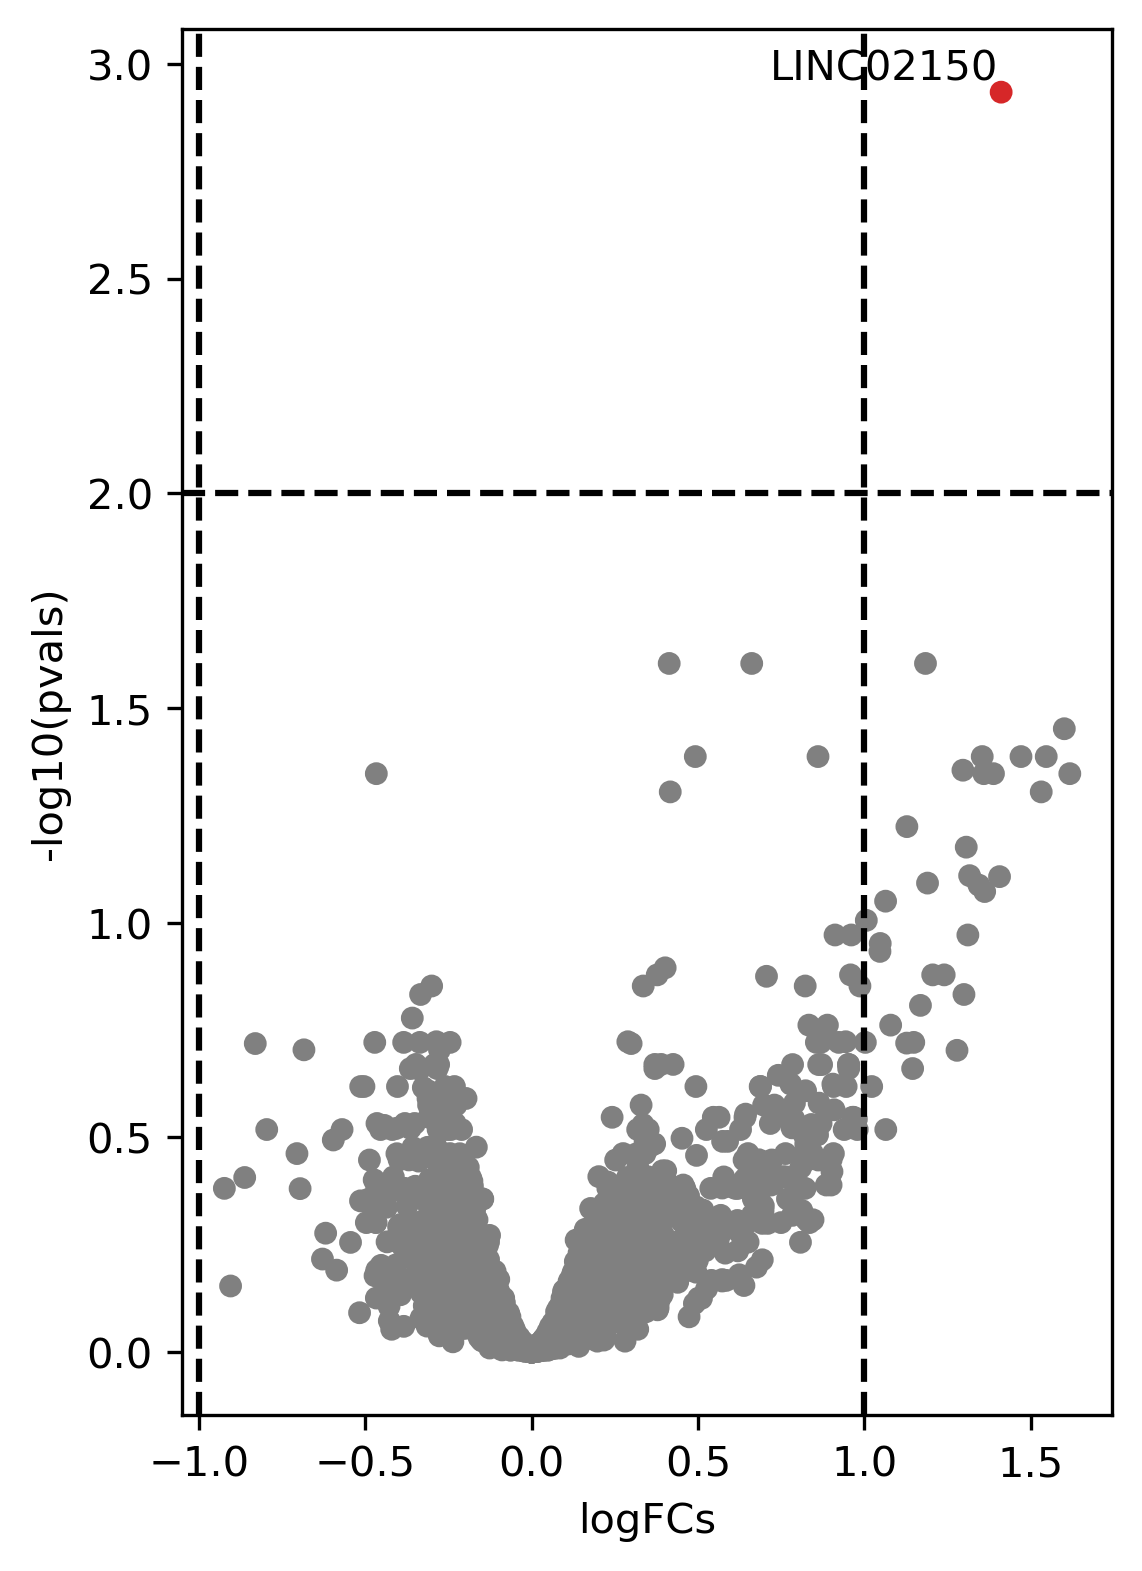

In [ ]:
# PLOT - volcano plot 
output_path = f'output/volcano_plot-{selected_cell_type}.png'

dc.plot_volcano_df(
    DGE_results_df,
    x           = 'log2FoldChange',
    y           = 'padj',   # Pvals = significance?
    top         = 20,       # Top N hits to label
    lFCs_thr    = 1,        # Log2 fold change threshold = magnitude?
    sign_thr    = 1e-2,     # Significance threshold
    figsize     = (4, 6),
    dpi         = 300,
    save        = output_path
)
print(f'Created file at: {output_path}')

#* TODO - run the other celltypes by making a separate JNB for each so we can explore the results